<a href="https://colab.research.google.com/github/VIVEKGANGA/model-factory/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.5/963.5 kB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 36.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.optim import Adadelta
import torch.optim as optim
import torchmetrics



In [ ]:
batch_size = 25
train_dataset = datasets.MNIST(root="dataset",
                            download=True,
                            train=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), # We use tuple as Normalize expects tuple for each channel For RGB: (mean_r, mean_g, neab_b)
                                                     (0.3015,))]))
test_dataset = datasets.MNIST(root="dataset",
                            download=True,
                            train=False,
                            transform=transforms.Compose([
                            transforms.ToTensor(), transforms.Normalize((0.1307,),
                                                                        (0.3015,))]))

train_loader = DataLoader(dataset=train_dataset,
                          batch_size = batch_size,
                          shuffle=True,
                          )
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=True,
                         )


100%|██████████| 9.91M/9.91M [00:02<00:00, 4.55MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.29MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.16MB/s]


In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.cn1 = nn.Conv2d(1, 16, 3, 1) #Output size = 28 - 3 +1 = 26; Shape [16, 26, 26]
        self.cn2 = nn.Conv2d(16, 32, 3, 1) #Output size = 26 - 3 + 1 = 24; Shape [32, 24, 24]
        self.dp1 = nn.Dropout2d(0.10) # Max pooling with kernel=2 reduces H and W by half. Shape [32, 12, 12]
        self.dp2 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(4608, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.cn1(x) #Shape [bs, 16, 26, 26]
        x = F.relu(x)
        x = self.cn2(x) #Shape [bs, 32, 24, 24]
        x = F.relu(x)
        x = F.max_pool2d(x, 2) #Shape [bs, 32, 12, 12]
        x = self.dp1(x)
        x = torch.flatten(x, 1) # Shape [bs, 32* 12* 12]
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp2(x)
        x = self.fc2(x)
        op = F.log_softmax(x, dim=1)
        return op

In [ ]:
def train(model, train_loader, device, optim, epoch):
    model.train()
    for b_i, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device)
        optim.zero_grad()
        pred_prob = model(X)
        loss = F.nll_loss(pred_prob, y)
        loss.backward()
        optim.step()
        if b_i % 10 == 0:
            print('epoch: {} [{}/{} ({:.0f}%)]\t training loss: {:.6f}'.format(
                epoch, b_i * len(X), len(train_loader.dataset),
                100. * b_i / len(train_loader), loss.item()))


In [ ]:
def test(model, test_loader, device):
    model.eval()
    loss = 0
    success = 0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            pred_prob = model(X)
            loss += F.nll_loss(pred_prob, y, reduction='sum').item()  # loss summed across the batch
            pred = pred_prob.argmax(dim=1, keepdim=True)
            success += pred.eq(y.view_as(pred)).sum().item()

    loss /= len(test_loader.dataset)

    print('\nTest dataset: Overall Loss: {:.4f}, Overall Accuracy: {}/{} ({:.0f}%)\n'.format(
        loss, success, len(test_loader.dataset),
        100. * success / len(test_loader.dataset)))



In [ ]:
torch.manual_seed(0)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model = ConvNet()
model.to(device)
optimizer = Adadelta(model.parameters(), lr=0.5)

In [ ]:
for epoch in range(1, 3):
    train(model, train_loader, device, optimizer, epoch)
    test(model, test_loader, device)

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [0/60000 (0%)]	 training loss: 2.310262
epoch: 1 [250/60000 (0%)]	 training loss: 1.817381
epoch: 1 [500/60000 (1%)]	 training loss: 1.289304
epoch: 1 [750/60000 (1%)]	 training loss: 0.671818


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [1000/60000 (2%)]	 training loss: 0.623901
epoch: 1 [1250/60000 (2%)]	 training loss: 0.773457
epoch: 1 [1500/60000 (2%)]	 training loss: 0.570300
epoch: 1 [1750/60000 (3%)]	 training loss: 0.365574
epoch: 1 [2000/60000 (3%)]	 training loss: 0.625708
epoch: 1 [2250/60000 (4%)]	 training loss: 0.216320
epoch: 1 [2500/60000 (4%)]	 training loss: 0.324429
epoch: 1 [2750/60000 (5%)]	 training loss: 0.517417
epoch: 1 [3000/60000 (5%)]	 training loss: 0.393606
epoch: 1 [3250/60000 (5%)]	 training loss: 0.318301
epoch: 1 [3500/60000 (6%)]	 training loss: 0.211079


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [3750/60000 (6%)]	 training loss: 0.202843
epoch: 1 [4000/60000 (7%)]	 training loss: 0.153160
epoch: 1 [4250/60000 (7%)]	 training loss: 0.166638
epoch: 1 [4500/60000 (8%)]	 training loss: 0.105399
epoch: 1 [4750/60000 (8%)]	 training loss: 0.181029
epoch: 1 [5000/60000 (8%)]	 training loss: 0.184630
epoch: 1 [5250/60000 (9%)]	 training loss: 0.230794
epoch: 1 [5500/60000 (9%)]	 training loss: 0.055050


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [5750/60000 (10%)]	 training loss: 0.203546
epoch: 1 [6000/60000 (10%)]	 training loss: 0.238627
epoch: 1 [6250/60000 (10%)]	 training loss: 0.071821
epoch: 1 [6500/60000 (11%)]	 training loss: 0.251930
epoch: 1 [6750/60000 (11%)]	 training loss: 0.031246
epoch: 1 [7000/60000 (12%)]	 training loss: 0.242981


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [7250/60000 (12%)]	 training loss: 0.206369
epoch: 1 [7500/60000 (12%)]	 training loss: 0.227847


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [7750/60000 (13%)]	 training loss: 0.036371
epoch: 1 [8000/60000 (13%)]	 training loss: 0.212439
epoch: 1 [8250/60000 (14%)]	 training loss: 0.104276
epoch: 1 [8500/60000 (14%)]	 training loss: 0.581859


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [8750/60000 (15%)]	 training loss: 0.092884
epoch: 1 [9000/60000 (15%)]	 training loss: 0.075738
epoch: 1 [9250/60000 (15%)]	 training loss: 0.263801
epoch: 1 [9500/60000 (16%)]	 training loss: 0.031678


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [9750/60000 (16%)]	 training loss: 0.334501
epoch: 1 [10000/60000 (17%)]	 training loss: 0.041151
epoch: 1 [10250/60000 (17%)]	 training loss: 0.027630
epoch: 1 [10500/60000 (18%)]	 training loss: 0.087330
epoch: 1 [10750/60000 (18%)]	 training loss: 0.341290
epoch: 1 [11000/60000 (18%)]	 training loss: 0.266157


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [11250/60000 (19%)]	 training loss: 0.358282
epoch: 1 [11500/60000 (19%)]	 training loss: 0.065596
epoch: 1 [11750/60000 (20%)]	 training loss: 0.124821


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [12000/60000 (20%)]	 training loss: 0.083943
epoch: 1 [12250/60000 (20%)]	 training loss: 0.169477
epoch: 1 [12500/60000 (21%)]	 training loss: 0.079327
epoch: 1 [12750/60000 (21%)]	 training loss: 0.449297
epoch: 1 [13000/60000 (22%)]	 training loss: 0.029790
epoch: 1 [13250/60000 (22%)]	 training loss: 0.025605
epoch: 1 [13500/60000 (22%)]	 training loss: 0.032864


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [13750/60000 (23%)]	 training loss: 0.317547
epoch: 1 [14000/60000 (23%)]	 training loss: 0.545704
epoch: 1 [14250/60000 (24%)]	 training loss: 0.190191
epoch: 1 [14500/60000 (24%)]	 training loss: 0.139981


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [14750/60000 (25%)]	 training loss: 0.017034
epoch: 1 [15000/60000 (25%)]	 training loss: 0.248869
epoch: 1 [15250/60000 (25%)]	 training loss: 0.083775
epoch: 1 [15500/60000 (26%)]	 training loss: 0.099894
epoch: 1 [15750/60000 (26%)]	 training loss: 0.043978
epoch: 1 [16000/60000 (27%)]	 training loss: 0.022166


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [16250/60000 (27%)]	 training loss: 0.022950
epoch: 1 [16500/60000 (28%)]	 training loss: 0.177721


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [16750/60000 (28%)]	 training loss: 0.083842
epoch: 1 [17000/60000 (28%)]	 training loss: 0.218734
epoch: 1 [17250/60000 (29%)]	 training loss: 0.222132
epoch: 1 [17500/60000 (29%)]	 training loss: 0.093352


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [17750/60000 (30%)]	 training loss: 0.057779
epoch: 1 [18000/60000 (30%)]	 training loss: 0.107747
epoch: 1 [18250/60000 (30%)]	 training loss: 0.023156
epoch: 1 [18500/60000 (31%)]	 training loss: 0.241329
epoch: 1 [18750/60000 (31%)]	 training loss: 0.148642
epoch: 1 [19000/60000 (32%)]	 training loss: 0.008898


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [19250/60000 (32%)]	 training loss: 0.041539
epoch: 1 [19500/60000 (32%)]	 training loss: 0.047648
epoch: 1 [19750/60000 (33%)]	 training loss: 0.151195
epoch: 1 [20000/60000 (33%)]	 training loss: 0.135323
epoch: 1 [20250/60000 (34%)]	 training loss: 0.110272


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [20500/60000 (34%)]	 training loss: 0.116282
epoch: 1 [20750/60000 (35%)]	 training loss: 0.054406
epoch: 1 [21000/60000 (35%)]	 training loss: 0.155088
epoch: 1 [21250/60000 (35%)]	 training loss: 0.125607


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [21500/60000 (36%)]	 training loss: 0.105328
epoch: 1 [21750/60000 (36%)]	 training loss: 0.191108
epoch: 1 [22000/60000 (37%)]	 training loss: 0.020382
epoch: 1 [22250/60000 (37%)]	 training loss: 0.107058


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [22500/60000 (38%)]	 training loss: 0.181704
epoch: 1 [22750/60000 (38%)]	 training loss: 0.126099
epoch: 1 [23000/60000 (38%)]	 training loss: 0.038311
epoch: 1 [23250/60000 (39%)]	 training loss: 0.004204
epoch: 1 [23500/60000 (39%)]	 training loss: 0.011135


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [23750/60000 (40%)]	 training loss: 0.158697
epoch: 1 [24000/60000 (40%)]	 training loss: 0.058068
epoch: 1 [24250/60000 (40%)]	 training loss: 0.145863
epoch: 1 [24500/60000 (41%)]	 training loss: 0.089503
epoch: 1 [24750/60000 (41%)]	 training loss: 0.478273
epoch: 1 [25000/60000 (42%)]	 training loss: 0.012973
epoch: 1 [25250/60000 (42%)]	 training loss: 0.513661
epoch: 1 [25500/60000 (42%)]	 training loss: 0.166142
epoch: 1 [25750/60000 (43%)]	 training loss: 0.012230


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [26000/60000 (43%)]	 training loss: 0.016688
epoch: 1 [26250/60000 (44%)]	 training loss: 0.058007


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [26500/60000 (44%)]	 training loss: 0.031342
epoch: 1 [26750/60000 (45%)]	 training loss: 0.012783
epoch: 1 [27000/60000 (45%)]	 training loss: 0.023020
epoch: 1 [27250/60000 (45%)]	 training loss: 0.276965
epoch: 1 [27500/60000 (46%)]	 training loss: 0.019402


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [27750/60000 (46%)]	 training loss: 0.125954
epoch: 1 [28000/60000 (47%)]	 training loss: 0.015865
epoch: 1 [28250/60000 (47%)]	 training loss: 0.084318
epoch: 1 [28500/60000 (48%)]	 training loss: 0.065946
epoch: 1 [28750/60000 (48%)]	 training loss: 0.011892


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [29000/60000 (48%)]	 training loss: 0.337810
epoch: 1 [29250/60000 (49%)]	 training loss: 0.087451
epoch: 1 [29500/60000 (49%)]	 training loss: 0.225647
epoch: 1 [29750/60000 (50%)]	 training loss: 0.018207
epoch: 1 [30000/60000 (50%)]	 training loss: 0.176894
epoch: 1 [30250/60000 (50%)]	 training loss: 0.057081


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [30500/60000 (51%)]	 training loss: 0.278805
epoch: 1 [30750/60000 (51%)]	 training loss: 0.256665
epoch: 1 [31000/60000 (52%)]	 training loss: 0.104836
epoch: 1 [31250/60000 (52%)]	 training loss: 0.053091
epoch: 1 [31500/60000 (52%)]	 training loss: 0.026336
epoch: 1 [31750/60000 (53%)]	 training loss: 0.164728
epoch: 1 [32000/60000 (53%)]	 training loss: 0.004316


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [32250/60000 (54%)]	 training loss: 0.223601


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [32500/60000 (54%)]	 training loss: 0.066551
epoch: 1 [32750/60000 (55%)]	 training loss: 0.075279


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [33000/60000 (55%)]	 training loss: 0.245799
epoch: 1 [33250/60000 (55%)]	 training loss: 0.043882
epoch: 1 [33500/60000 (56%)]	 training loss: 0.034006
epoch: 1 [33750/60000 (56%)]	 training loss: 0.055540


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [34000/60000 (57%)]	 training loss: 0.048307
epoch: 1 [34250/60000 (57%)]	 training loss: 0.009323
epoch: 1 [34500/60000 (58%)]	 training loss: 0.002833
epoch: 1 [34750/60000 (58%)]	 training loss: 0.019661
epoch: 1 [35000/60000 (58%)]	 training loss: 0.008818
epoch: 1 [35250/60000 (59%)]	 training loss: 0.038279
epoch: 1 [35500/60000 (59%)]	 training loss: 0.047172
epoch: 1 [35750/60000 (60%)]	 training loss: 0.017032


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [36000/60000 (60%)]	 training loss: 0.245561
epoch: 1 [36250/60000 (60%)]	 training loss: 0.258945
epoch: 1 [36500/60000 (61%)]	 training loss: 0.011713


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [36750/60000 (61%)]	 training loss: 0.034209
epoch: 1 [37000/60000 (62%)]	 training loss: 0.053869
epoch: 1 [37250/60000 (62%)]	 training loss: 0.055083
epoch: 1 [37500/60000 (62%)]	 training loss: 0.075372
epoch: 1 [37750/60000 (63%)]	 training loss: 0.039684


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [38000/60000 (63%)]	 training loss: 0.021371
epoch: 1 [38250/60000 (64%)]	 training loss: 0.113996
epoch: 1 [38500/60000 (64%)]	 training loss: 0.023138
epoch: 1 [38750/60000 (65%)]	 training loss: 0.387305
epoch: 1 [39000/60000 (65%)]	 training loss: 0.008749


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [39250/60000 (65%)]	 training loss: 0.011848
epoch: 1 [39500/60000 (66%)]	 training loss: 0.070432
epoch: 1 [39750/60000 (66%)]	 training loss: 0.008865
epoch: 1 [40000/60000 (67%)]	 training loss: 0.105098
epoch: 1 [40250/60000 (67%)]	 training loss: 0.214070


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [40500/60000 (68%)]	 training loss: 0.032561
epoch: 1 [40750/60000 (68%)]	 training loss: 0.179410
epoch: 1 [41000/60000 (68%)]	 training loss: 0.008147
epoch: 1 [41250/60000 (69%)]	 training loss: 0.006276
epoch: 1 [41500/60000 (69%)]	 training loss: 0.039802


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [41750/60000 (70%)]	 training loss: 0.039932
epoch: 1 [42000/60000 (70%)]	 training loss: 0.009211
epoch: 1 [42250/60000 (70%)]	 training loss: 0.011392
epoch: 1 [42500/60000 (71%)]	 training loss: 0.306158
epoch: 1 [42750/60000 (71%)]	 training loss: 0.004418
epoch: 1 [43000/60000 (72%)]	 training loss: 0.038566


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [43250/60000 (72%)]	 training loss: 0.090390
epoch: 1 [43500/60000 (72%)]	 training loss: 0.264439
epoch: 1 [43750/60000 (73%)]	 training loss: 0.022975
epoch: 1 [44000/60000 (73%)]	 training loss: 0.026906


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [44250/60000 (74%)]	 training loss: 0.026217
epoch: 1 [44500/60000 (74%)]	 training loss: 0.084315
epoch: 1 [44750/60000 (75%)]	 training loss: 0.020222
epoch: 1 [45000/60000 (75%)]	 training loss: 0.044819
epoch: 1 [45250/60000 (75%)]	 training loss: 0.025579


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [45500/60000 (76%)]	 training loss: 0.014197
epoch: 1 [45750/60000 (76%)]	 training loss: 0.138991
epoch: 1 [46000/60000 (77%)]	 training loss: 0.033433
epoch: 1 [46250/60000 (77%)]	 training loss: 0.001286


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [46500/60000 (78%)]	 training loss: 0.002316
epoch: 1 [46750/60000 (78%)]	 training loss: 0.065126
epoch: 1 [47000/60000 (78%)]	 training loss: 0.023496


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [47250/60000 (79%)]	 training loss: 0.014312
epoch: 1 [47500/60000 (79%)]	 training loss: 0.189934
epoch: 1 [47750/60000 (80%)]	 training loss: 0.133849
epoch: 1 [48000/60000 (80%)]	 training loss: 0.021404


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [48250/60000 (80%)]	 training loss: 0.212634
epoch: 1 [48500/60000 (81%)]	 training loss: 0.126144
epoch: 1 [48750/60000 (81%)]	 training loss: 0.047717
epoch: 1 [49000/60000 (82%)]	 training loss: 0.001827
epoch: 1 [49250/60000 (82%)]	 training loss: 0.214586
epoch: 1 [49500/60000 (82%)]	 training loss: 0.128274
epoch: 1 [49750/60000 (83%)]	 training loss: 0.302150
epoch: 1 [50000/60000 (83%)]	 training loss: 0.040909
epoch: 1 [50250/60000 (84%)]	 training loss: 0.119976


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [50500/60000 (84%)]	 training loss: 0.093990
epoch: 1 [50750/60000 (85%)]	 training loss: 0.002236


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [51000/60000 (85%)]	 training loss: 0.010561
epoch: 1 [51250/60000 (85%)]	 training loss: 0.081630
epoch: 1 [51500/60000 (86%)]	 training loss: 0.069405
epoch: 1 [51750/60000 (86%)]	 training loss: 0.264452


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [52000/60000 (87%)]	 training loss: 0.039108
epoch: 1 [52250/60000 (87%)]	 training loss: 0.092776
epoch: 1 [52500/60000 (88%)]	 training loss: 0.075538
epoch: 1 [52750/60000 (88%)]	 training loss: 0.027474
epoch: 1 [53000/60000 (88%)]	 training loss: 0.086668


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [53250/60000 (89%)]	 training loss: 0.008717
epoch: 1 [53500/60000 (89%)]	 training loss: 0.023781
epoch: 1 [53750/60000 (90%)]	 training loss: 0.071241
epoch: 1 [54000/60000 (90%)]	 training loss: 0.177590
epoch: 1 [54250/60000 (90%)]	 training loss: 0.006318
epoch: 1 [54500/60000 (91%)]	 training loss: 0.046727


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [54750/60000 (91%)]	 training loss: 0.006915
epoch: 1 [55000/60000 (92%)]	 training loss: 0.290867
epoch: 1 [55250/60000 (92%)]	 training loss: 0.094054
epoch: 1 [55500/60000 (92%)]	 training loss: 0.084657
epoch: 1 [55750/60000 (93%)]	 training loss: 0.462453
epoch: 1 [56000/60000 (93%)]	 training loss: 0.218277
epoch: 1 [56250/60000 (94%)]	 training loss: 0.037099
epoch: 1 [56500/60000 (94%)]	 training loss: 0.032755


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [56750/60000 (95%)]	 training loss: 0.081931


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [57000/60000 (95%)]	 training loss: 0.175148
epoch: 1 [57250/60000 (95%)]	 training loss: 0.140553
epoch: 1 [57500/60000 (96%)]	 training loss: 0.162110
epoch: 1 [57750/60000 (96%)]	 training loss: 0.120461
epoch: 1 [58000/60000 (97%)]	 training loss: 0.044870
epoch: 1 [58250/60000 (97%)]	 training loss: 0.019574


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [58500/60000 (98%)]	 training loss: 0.004525
epoch: 1 [58750/60000 (98%)]	 training loss: 0.040083
epoch: 1 [59000/60000 (98%)]	 training loss: 0.023111
epoch: 1 [59250/60000 (99%)]	 training loss: 0.102120
epoch: 1 [59500/60000 (99%)]	 training loss: 0.211662


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [59750/60000 (100%)]	 training loss: 0.011943


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
/usr/local/lib/python3.11/dist-packages/torch/nn/funct


Test dataset: Overall Loss: 0.0553, Overall Accuracy: 9818/10000 (98%)

epoch: 2 [0/60000 (0%)]	 training loss: 0.008035
epoch: 2 [250/60000 (0%)]	 training loss: 0.055325
epoch: 2 [500/60000 (1%)]	 training loss: 0.069830
epoch: 2 [750/60000 (1%)]	 training loss: 0.253672
epoch: 2 [1000/60000 (2%)]	 training loss: 0.019598


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 2 [1250/60000 (2%)]	 training loss: 0.005925
epoch: 2 [1500/60000 (2%)]	 training loss: 0.012271
epoch: 2 [1750/60000 (3%)]	 training loss: 0.018338
epoch: 2 [2000/60000 (3%)]	 training loss: 0.007376


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 2 [2250/60000 (4%)]	 training loss: 0.021525
epoch: 2 [2500/60000 (4%)]	 training loss: 0.061019
epoch: 2 [2750/60000 (5%)]	 training loss: 0.026262
epoch: 2 [3000/60000 (5%)]	 training loss: 0.011937
epoch: 2 [3250/60000 (5%)]	 training loss: 0.017644


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 2 [3500/60000 (6%)]	 training loss: 0.090422
epoch: 2 [3750/60000 (6%)]	 training loss: 0.070191
epoch: 2 [4000/60000 (7%)]	 training loss: 0.016625
epoch: 2 [4250/60000 (7%)]	 training loss: 0.086329
epoch: 2 [4500/60000 (8%)]	 training loss: 0.023854
epoch: 2 [4750/60000 (8%)]	 training loss: 0.063498


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 2 [5000/60000 (8%)]	 training loss: 0.006441
epoch: 2 [5250/60000 (9%)]	 training loss: 0.017498


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 2 [5500/60000 (9%)]	 training loss: 0.001497
epoch: 2 [5750/60000 (10%)]	 training loss: 0.015559
epoch: 2 [6000/60000 (10%)]	 training loss: 0.044819
epoch: 2 [6250/60000 (10%)]	 training loss: 0.037478
epoch: 2 [6500/60000 (11%)]	 training loss: 0.005314
epoch: 2 [6750/60000 (11%)]	 training loss: 0.049512
epoch: 2 [7000/60000 (12%)]	 training loss: 0.006110


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 2 [7250/60000 (12%)]	 training loss: 0.035595
epoch: 2 [7500/60000 (12%)]	 training loss: 0.354992
epoch: 2 [7750/60000 (13%)]	 training loss: 0.046796
epoch: 2 [8000/60000 (13%)]	 training loss: 0.154391
epoch: 2 [8250/60000 (14%)]	 training loss: 0.018605


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 2 [8500/60000 (14%)]	 training loss: 0.021495
epoch: 2 [8750/60000 (15%)]	 training loss: 0.054959
epoch: 2 [9000/60000 (15%)]	 training loss: 0.019423
epoch: 2 [9250/60000 (15%)]	 training loss: 0.176975


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 2 [9500/60000 (16%)]	 training loss: 0.284165
epoch: 2 [9750/60000 (16%)]	 training loss: 0.032784
epoch: 2 [10000/60000 (17%)]	 training loss: 0.100944
epoch: 2 [10250/60000 (17%)]	 training loss: 0.015041


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 2 [10500/60000 (18%)]	 training loss: 0.003099
epoch: 2 [10750/60000 (18%)]	 training loss: 0.004932
epoch: 2 [11000/60000 (18%)]	 training loss: 0.087504


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 2 [11250/60000 (19%)]	 training loss: 0.061503
epoch: 2 [11500/60000 (19%)]	 training loss: 0.034044
epoch: 2 [11750/60000 (20%)]	 training loss: 0.304084
epoch: 2 [12000/60000 (20%)]	 training loss: 0.084689
epoch: 2 [12250/60000 (20%)]	 training loss: 0.308175


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 2 [12500/60000 (21%)]	 training loss: 0.302362
epoch: 2 [12750/60000 (21%)]	 training loss: 0.006496
epoch: 2 [13000/60000 (22%)]	 training loss: 0.179064
epoch: 2 [13250/60000 (22%)]	 training loss: 0.030123
epoch: 2 [13500/60000 (22%)]	 training loss: 0.005805


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 2 [13750/60000 (23%)]	 training loss: 0.051977
epoch: 2 [14000/60000 (23%)]	 training loss: 0.234865
epoch: 2 [14250/60000 (24%)]	 training loss: 0.019300
epoch: 2 [14500/60000 (24%)]	 training loss: 0.246108


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 2 [14750/60000 (25%)]	 training loss: 0.017640
epoch: 2 [15000/60000 (25%)]	 training loss: 0.225481
epoch: 2 [15250/60000 (25%)]	 training loss: 0.151936
epoch: 2 [15500/60000 (26%)]	 training loss: 0.007219
epoch: 2 [15750/60000 (26%)]	 training loss: 0.211953


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 2 [16000/60000 (27%)]	 training loss: 0.040483
epoch: 2 [16250/60000 (27%)]	 training loss: 0.173394
epoch: 2 [16500/60000 (28%)]	 training loss: 0.212578


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 2 [16750/60000 (28%)]	 training loss: 0.135440
epoch: 2 [17000/60000 (28%)]	 training loss: 0.025759
epoch: 2 [17250/60000 (29%)]	 training loss: 0.011361
epoch: 2 [17500/60000 (29%)]	 training loss: 0.468378
epoch: 2 [17750/60000 (30%)]	 training loss: 0.077180


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 2 [18000/60000 (30%)]	 training loss: 0.083348
epoch: 2 [18250/60000 (30%)]	 training loss: 0.006527
epoch: 2 [18500/60000 (31%)]	 training loss: 0.014734
epoch: 2 [18750/60000 (31%)]	 training loss: 0.002703
epoch: 2 [19000/60000 (32%)]	 training loss: 0.073796


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 2 [19250/60000 (32%)]	 training loss: 0.298936
epoch: 2 [19500/60000 (32%)]	 training loss: 0.007231
epoch: 2 [19750/60000 (33%)]	 training loss: 0.008154
epoch: 2 [20000/60000 (33%)]	 training loss: 0.020731
epoch: 2 [20250/60000 (34%)]	 training loss: 0.025327
epoch: 2 [20500/60000 (34%)]	 training loss: 0.001204
epoch: 2 [20750/60000 (35%)]	 training loss: 0.039780


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 2 [21000/60000 (35%)]	 training loss: 0.278725
epoch: 2 [21250/60000 (35%)]	 training loss: 0.243138
epoch: 2 [21500/60000 (36%)]	 training loss: 0.017416
epoch: 2 [21750/60000 (36%)]	 training loss: 0.236863


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 2 [22000/60000 (37%)]	 training loss: 0.096894
epoch: 2 [22250/60000 (37%)]	 training loss: 0.006900
epoch: 2 [22500/60000 (38%)]	 training loss: 0.059380
epoch: 2 [22750/60000 (38%)]	 training loss: 0.003698
epoch: 2 [23000/60000 (38%)]	 training loss: 0.089737


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 2 [23250/60000 (39%)]	 training loss: 0.015137
epoch: 2 [23500/60000 (39%)]	 training loss: 0.004127
epoch: 2 [23750/60000 (40%)]	 training loss: 0.015539
epoch: 2 [24000/60000 (40%)]	 training loss: 0.009379
epoch: 2 [24250/60000 (40%)]	 training loss: 0.092381


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 2 [24500/60000 (41%)]	 training loss: 0.025069
epoch: 2 [24750/60000 (41%)]	 training loss: 0.045550
epoch: 2 [25000/60000 (42%)]	 training loss: 0.015240


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 2 [25250/60000 (42%)]	 training loss: 0.031925
epoch: 2 [25500/60000 (42%)]	 training loss: 0.017433
epoch: 2 [25750/60000 (43%)]	 training loss: 0.026486


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 2 [26000/60000 (43%)]	 training loss: 0.125857
epoch: 2 [26250/60000 (44%)]	 training loss: 0.197855
epoch: 2 [26500/60000 (44%)]	 training loss: 0.025864
epoch: 2 [26750/60000 (45%)]	 training loss: 0.001433
epoch: 2 [27000/60000 (45%)]	 training loss: 0.050465


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 2 [27250/60000 (45%)]	 training loss: 0.103590
epoch: 2 [27500/60000 (46%)]	 training loss: 0.041847
epoch: 2 [27750/60000 (46%)]	 training loss: 0.026134
epoch: 2 [28000/60000 (47%)]	 training loss: 0.000112
epoch: 2 [28250/60000 (47%)]	 training loss: 0.118817


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 2 [28500/60000 (48%)]	 training loss: 0.005279
epoch: 2 [28750/60000 (48%)]	 training loss: 0.003213
epoch: 2 [29000/60000 (48%)]	 training loss: 0.308192
epoch: 2 [29250/60000 (49%)]	 training loss: 0.014144
epoch: 2 [29500/60000 (49%)]	 training loss: 0.001747
epoch: 2 [29750/60000 (50%)]	 training loss: 0.018094
epoch: 2 [30000/60000 (50%)]	 training loss: 0.000688
epoch: 2 [30250/60000 (50%)]	 training loss: 0.145513
epoch: 2 [30500/60000 (51%)]	 training loss: 0.427700


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 2 [30750/60000 (51%)]	 training loss: 0.049024


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 2 [31000/60000 (52%)]	 training loss: 0.012357
epoch: 2 [31250/60000 (52%)]	 training loss: 0.026755
epoch: 2 [31500/60000 (52%)]	 training loss: 0.021179
epoch: 2 [31750/60000 (53%)]	 training loss: 0.009093
epoch: 2 [32000/60000 (53%)]	 training loss: 0.005229


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 2 [32250/60000 (54%)]	 training loss: 0.013645
epoch: 2 [32500/60000 (54%)]	 training loss: 0.007739
epoch: 2 [32750/60000 (55%)]	 training loss: 0.049727
epoch: 2 [33000/60000 (55%)]	 training loss: 0.424369


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 2 [33250/60000 (55%)]	 training loss: 0.025546
epoch: 2 [33500/60000 (56%)]	 training loss: 0.074874
epoch: 2 [33750/60000 (56%)]	 training loss: 0.037536
epoch: 2 [34000/60000 (57%)]	 training loss: 0.009654
epoch: 2 [34250/60000 (57%)]	 training loss: 0.104760
epoch: 2 [34500/60000 (58%)]	 training loss: 0.144660


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 2 [34750/60000 (58%)]	 training loss: 0.017618
epoch: 2 [35000/60000 (58%)]	 training loss: 0.066220
epoch: 2 [35250/60000 (59%)]	 training loss: 0.135177
epoch: 2 [35500/60000 (59%)]	 training loss: 0.023233
epoch: 2 [35750/60000 (60%)]	 training loss: 0.046944
epoch: 2 [36000/60000 (60%)]	 training loss: 0.028559


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 2 [36250/60000 (60%)]	 training loss: 0.007620
epoch: 2 [36500/60000 (61%)]	 training loss: 0.009268
epoch: 2 [36750/60000 (61%)]	 training loss: 0.030095
epoch: 2 [37000/60000 (62%)]	 training loss: 0.021531
epoch: 2 [37250/60000 (62%)]	 training loss: 0.065525
epoch: 2 [37500/60000 (62%)]	 training loss: 0.205290
epoch: 2 [37750/60000 (63%)]	 training loss: 0.135207
epoch: 2 [38000/60000 (63%)]	 training loss: 0.004630
epoch: 2 [38250/60000 (64%)]	 training loss: 0.148363


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 2 [38500/60000 (64%)]	 training loss: 0.025703
epoch: 2 [38750/60000 (65%)]	 training loss: 0.002894
epoch: 2 [39000/60000 (65%)]	 training loss: 0.067532


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 2 [39250/60000 (65%)]	 training loss: 0.015023
epoch: 2 [39500/60000 (66%)]	 training loss: 0.225584
epoch: 2 [39750/60000 (66%)]	 training loss: 0.003332
epoch: 2 [40000/60000 (67%)]	 training loss: 0.011926
epoch: 2 [40250/60000 (67%)]	 training loss: 0.015905
epoch: 2 [40500/60000 (68%)]	 training loss: 0.059004


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 2 [40750/60000 (68%)]	 training loss: 0.004157
epoch: 2 [41000/60000 (68%)]	 training loss: 0.005872


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 2 [41250/60000 (69%)]	 training loss: 0.016791
epoch: 2 [41500/60000 (69%)]	 training loss: 0.047822
epoch: 2 [41750/60000 (70%)]	 training loss: 0.000812
epoch: 2 [42000/60000 (70%)]	 training loss: 0.026613
epoch: 2 [42250/60000 (70%)]	 training loss: 0.002874


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 2 [42500/60000 (71%)]	 training loss: 0.014277
epoch: 2 [42750/60000 (71%)]	 training loss: 0.002675
epoch: 2 [43000/60000 (72%)]	 training loss: 0.005406
epoch: 2 [43250/60000 (72%)]	 training loss: 0.143747
epoch: 2 [43500/60000 (72%)]	 training loss: 0.187644
epoch: 2 [43750/60000 (73%)]	 training loss: 0.067917
epoch: 2 [44000/60000 (73%)]	 training loss: 0.190694
epoch: 2 [44250/60000 (74%)]	 training loss: 0.002922


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 2 [44500/60000 (74%)]	 training loss: 0.005305
epoch: 2 [44750/60000 (75%)]	 training loss: 0.112047


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 2 [45000/60000 (75%)]	 training loss: 0.030646
epoch: 2 [45250/60000 (75%)]	 training loss: 0.016352
epoch: 2 [45500/60000 (76%)]	 training loss: 0.958732
epoch: 2 [45750/60000 (76%)]	 training loss: 0.061436


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 2 [46000/60000 (77%)]	 training loss: 0.187628
epoch: 2 [46250/60000 (77%)]	 training loss: 0.022977
epoch: 2 [46500/60000 (78%)]	 training loss: 0.041788
epoch: 2 [46750/60000 (78%)]	 training loss: 0.021474
epoch: 2 [47000/60000 (78%)]	 training loss: 0.037113


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 2 [47250/60000 (79%)]	 training loss: 0.129456
epoch: 2 [47500/60000 (79%)]	 training loss: 0.008608
epoch: 2 [47750/60000 (80%)]	 training loss: 0.616839
epoch: 2 [48000/60000 (80%)]	 training loss: 0.003914


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 2 [48250/60000 (80%)]	 training loss: 0.314950
epoch: 2 [48500/60000 (81%)]	 training loss: 0.004836
epoch: 2 [48750/60000 (81%)]	 training loss: 0.009897
epoch: 2 [49000/60000 (82%)]	 training loss: 0.125204
epoch: 2 [49250/60000 (82%)]	 training loss: 0.011818
epoch: 2 [49500/60000 (82%)]	 training loss: 0.010297
epoch: 2 [49750/60000 (83%)]	 training loss: 0.085567


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 2 [50000/60000 (83%)]	 training loss: 0.004271
epoch: 2 [50250/60000 (84%)]	 training loss: 0.141426
epoch: 2 [50500/60000 (84%)]	 training loss: 0.406238
epoch: 2 [50750/60000 (85%)]	 training loss: 0.004684


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 2 [51000/60000 (85%)]	 training loss: 0.049587
epoch: 2 [51250/60000 (85%)]	 training loss: 0.001415
epoch: 2 [51500/60000 (86%)]	 training loss: 0.009750


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 2 [51750/60000 (86%)]	 training loss: 0.006809
epoch: 2 [52000/60000 (87%)]	 training loss: 0.046195
epoch: 2 [52250/60000 (87%)]	 training loss: 0.019613
epoch: 2 [52500/60000 (88%)]	 training loss: 0.007137
epoch: 2 [52750/60000 (88%)]	 training loss: 0.282446
epoch: 2 [53000/60000 (88%)]	 training loss: 0.073768


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 2 [53250/60000 (89%)]	 training loss: 0.002543
epoch: 2 [53500/60000 (89%)]	 training loss: 0.126846
epoch: 2 [53750/60000 (90%)]	 training loss: 0.105032


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 2 [54000/60000 (90%)]	 training loss: 0.033018
epoch: 2 [54250/60000 (90%)]	 training loss: 0.002673
epoch: 2 [54500/60000 (91%)]	 training loss: 0.547142
epoch: 2 [54750/60000 (91%)]	 training loss: 0.327123


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 2 [55000/60000 (92%)]	 training loss: 0.035225
epoch: 2 [55250/60000 (92%)]	 training loss: 0.103763
epoch: 2 [55500/60000 (92%)]	 training loss: 0.018276
epoch: 2 [55750/60000 (93%)]	 training loss: 0.008952


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 2 [56000/60000 (93%)]	 training loss: 0.003059
epoch: 2 [56250/60000 (94%)]	 training loss: 0.214775
epoch: 2 [56500/60000 (94%)]	 training loss: 0.006313


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 2 [56750/60000 (95%)]	 training loss: 0.195728
epoch: 2 [57000/60000 (95%)]	 training loss: 0.012870
epoch: 2 [57250/60000 (95%)]	 training loss: 0.005903
epoch: 2 [57500/60000 (96%)]	 training loss: 0.018131
epoch: 2 [57750/60000 (96%)]	 training loss: 0.007601
epoch: 2 [58000/60000 (97%)]	 training loss: 0.051297
epoch: 2 [58250/60000 (97%)]	 training loss: 0.116720


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 2 [58500/60000 (98%)]	 training loss: 0.003276
epoch: 2 [58750/60000 (98%)]	 training loss: 0.010441
epoch: 2 [59000/60000 (98%)]	 training loss: 0.002052
epoch: 2 [59250/60000 (99%)]	 training loss: 0.003402


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 2 [59500/60000 (99%)]	 training loss: 0.010426
epoch: 2 [59750/60000 (100%)]	 training loss: 0.123473


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
/usr/local/lib/python3.11/dist-packages/torch/nn/funct


Test dataset: Overall Loss: 0.0362, Overall Accuracy: 9883/10000 (99%)



In [ ]:
test_sample = enumerate(test_loader)

In [ ]:
import matplotlib.pyplot as plt

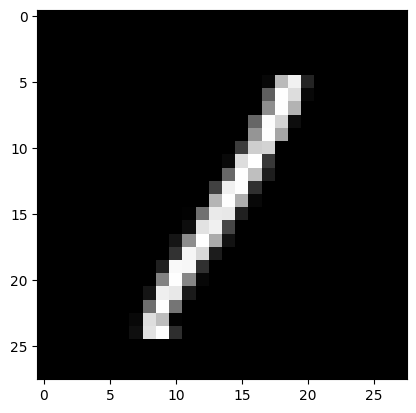

In [ ]:
b_i, (sample_data, sample_targets) = next(test_sample)
plt.imshow(sample_data[0][0], cmap='gray')

In [ ]:
print(f"Model prediction is : {model(sample_data).data.max(1)[1][0]}")
print(f"Actual label: {sample_targets[0]}")

Model prediction is : 1
Actual label: 1


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
